# 학습 목표
* 딥러닝 모델의 효과적인 학습을 위한 가중치 초기화에 대해 학습합니다.
* Reuters 데이터셋을 이용해 다중 분류를 위한 딥러닝 모델에 대해 학습합니다.
* 딥러닝 모델의 빠른 학습과 과대적합을 해결하는 배치 정규화 기술에 대해 학습합니다.

# 가중치 초기화(Weights Initialization)
* 가중치 초기화는 신경망의 성능에 큰 영향을 주는 요소 중 하나
* 가중치의 값이 일부 값으로 치우치게 되면, 활성화 함수를 통과한 값들도 치우치게 되고, 결국 표현할 수 있는 신경망의 수가 적어지는 문제가 발생
* 즉, 적절한 가중치 값이 주어지지 않을 경우 가중치 중 활성화되는 부분이 매우 적거나 편향될 수 있다.
* 보통 가중치 초기값으로 0에 가까운 무작위 값을 사용하더라도 초기값에 따라서 모델의 성능 차이가 발생
* 모델의 활성화 값이 골고루 분포 되는 것이 중요하다.

가중치 초기화 방법에 따라서 어떻게 달라지는지 살펴보기 위해 지정된 활성화 함수 activation과 초기화 initializer에 따라 모델을 생성하는 build_model 함수를 정의

In [1]:
# 함수 정의
from tensorflow.keras import models, layers, optimizers

def build_model(activation, initializer):
  model = models.Sequential()
  model.add(layers.Input(shape=(400, 20), name='input'))
  model.add(layers.Dense(20, activation=activation, name='hidden1', 
                        kernel_initializer=initializer))
  model.add(layers.Dense(20, activation=activation, name='hidden2', 
                        kernel_initializer=initializer))
  model.add(layers.Dense(20, activation=activation, name='hidden3', 
                        kernel_initializer=initializer))
  model.add(layers.Dense(20, activation=activation, name='hidden4', 
                        kernel_initializer=initializer))
  model.add(layers.Dense(20, activation=activation, name='hidden5', 
                        kernel_initializer=initializer))
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizers.SGD(),
                metrics=['accuracy'])
  return model

In [3]:
# 각 레이어마다 분포값을 히스토그램으로 출력하기 위한 show_layer 함수를 정의
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import initializers, activations

## 이부분 matplotlib 업데이트 되면서 없어진 부분
sns.set_style('white')
# plt.style.use('seaborn-white')

def show_layer(model):
  input = np.random.randn(400, 20)

  plt.figure(figsize=(12, 6))
  for i in range(1, 6):
    name = 'hidden' + str(i)
    layer = model.get_layer(name)
    input = layer(input)
    plt.subplot(1, 6, i)
    plt.title(name)
    # 이부분을 이렇게 고쳐줘야 표가 나옵니다 -> numpy로 바꿔주면 계산속도 up
    plt.hist(input.numpy().flatten(), bins=20, range=(-1, 1))
    # plt.hist(input, 20, range=(-1, 1))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
  plt.show()

## 선형 함수, 비선형 함수 가중치 초기화 방법에 따라 분포의 차이점

### 선형 함수 가중치 초기화
* 활성화 함수 중에서 activations.sigmoid를 사용하여 초기화 방법들을 비교해보기
* sigmoid 함수는 전체적으로는 볼 때 비선형 함수이지만 특정 범위(-1, 1)에서는 선형 함수이다.
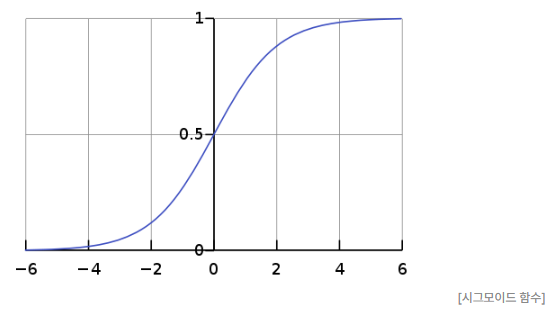
* 이미지 출처 : 위키백과

#### 제로 초기화
* 가중치를 제로값으로 초기화할 경우 각 레이어의 가중치 값 분포가 특정한 값으로만 몰려있다.
* 가중치 값이 0일 경우에는 오차역전파에서 모든 가중치 값이 똑같이 갱신되어 학습 진행 불가
> 참고: 각 레이어의 값이 0.5에 몰려 있는 이유는 가중치 값이 활성화 함수로 사용한 sigmoid 함수를 통과하였기 때문입니다. (sigmoid(0)=0.5)

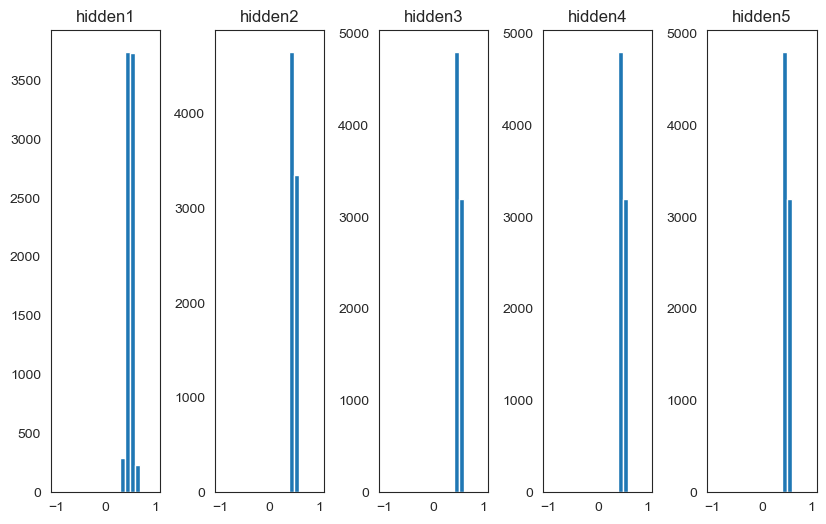

In [4]:
# initializers.RandomNormal()를 통해 정규분포를 따르도록 무작위 값을 초기화
model = build_model(activations.sigmoid, initializers.RandomNormal())
show_layer(model)

#### 정규분포 초기화
* 정규분포를 따르도록 무작위 값을 초기화하면 제로 초기화보다는 분포가 퍼져있는 것을 알 수 있다.
* 한 곳에 치우쳐 있기 때문에 여전히 신경망의 표현을 제한한다는 문제가 있다.

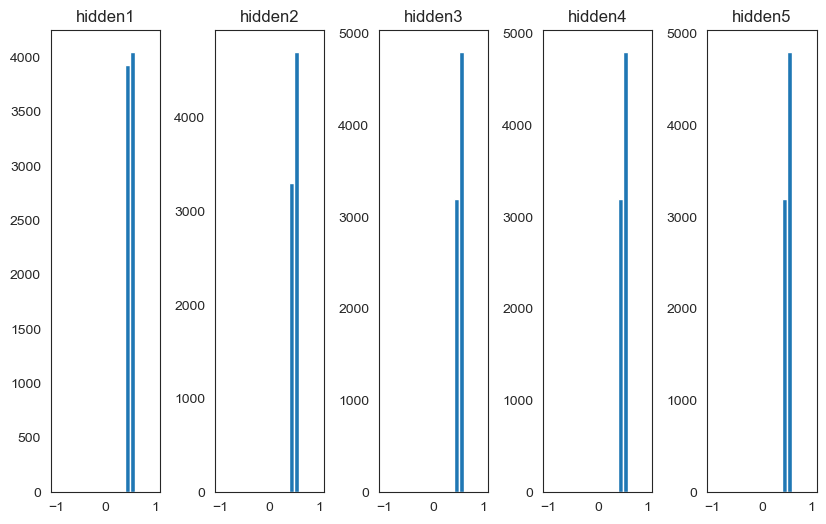

In [5]:
# initializers.RandomNormal()를 통해 정규분포를 따르도록 무작위 값을 초기화해 봅시다.
model = build_model(activations.sigmoid, initializers.RandomUniform())
show_layer(model)

#### 균일분포 초기화
* 균일분포를 따르는 무작위 값으로 초기화한 결과도 제로 초기화보다는 분포가 퍼져있는 것을 알 수 있다.
* 활성화 값이 균일하지 않으므로 역전파로 전해지는 기울기 값이 사라질 수 있다.

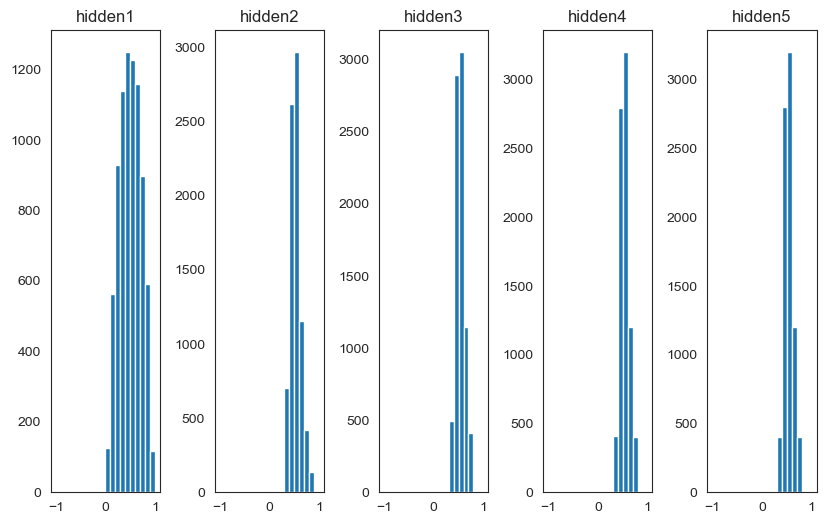

In [6]:
# initializers.RandomUniform()를 통해 균일분포를 따르는 무작위 값으로 초기화헤 봅시다.
model = build_model(activations.sigmoid, initializers.GlorotNormal())
show_layer(model)

#### Xavier(Glorot) 정규분포 초기화
* Xavier(Glorot) 방법은 은닉층의 노드의 수가 $n$ 이라면 **표준편차가 $\frac{1}{\sqrt{n}}$인 분포로 초기화**를 수행한다.
* `initializers.GlorotNormal()`를 적용한 모델을 시각화한 결과를 보면 비교적 분포로 고르고 레이어마다 표현이 잘 되고 있는 것을 알 수 있다.
* 즉, 더 많은 가중치에 역전파가 전달이 가능하게 된다.
* 일반적으로 Xavier(Glorot) 방법은 활성화 함수가 선형함수인 경우에 매우 적합하다.

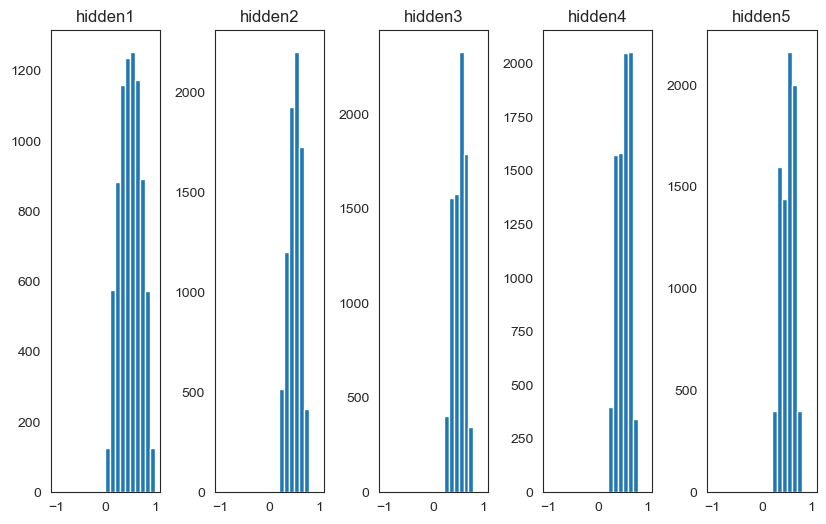

In [8]:
#initializers.GlorotNormal()를 적용한 모델을 시각화해 봅시다.
model = build_model(activations.sigmoid, initializers.GlorotNormal())
show_layer(model)

#### Xavier(Glorot) 균일분포 초기화
* initializers.GlorotUniform()를 통해 Xavier(Glorot) 균일분포 초기화를 이용한 결과도 마찬가지로 잘 분포되어 있다.
* 활성화 함수를 sigmoid 대신 tanh를 적용한 결과, 좀 더 균일한 분포의 모습을 보이는 것을 알 수 있다.

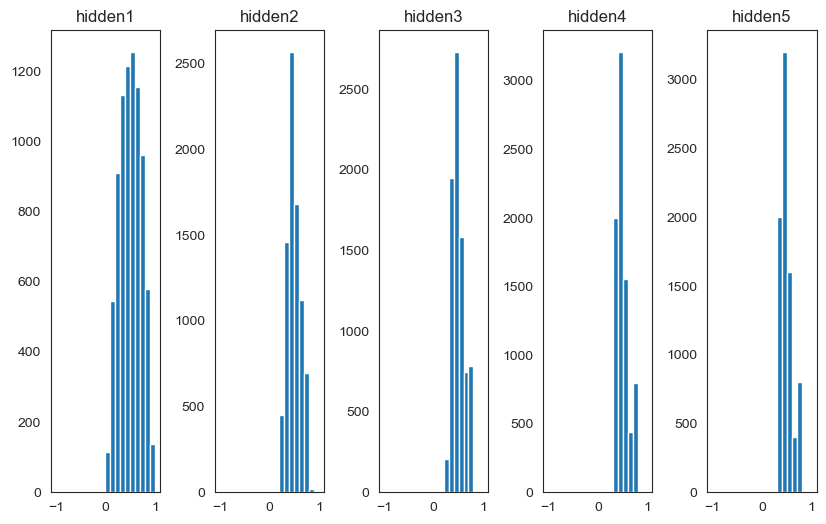

In [12]:
# initializers.GlorotUniform()으로 Xavier 균일분포 초기화
model = build_model(activations.sigmoid, initializers.GlorotUniform())
show_layer(model)

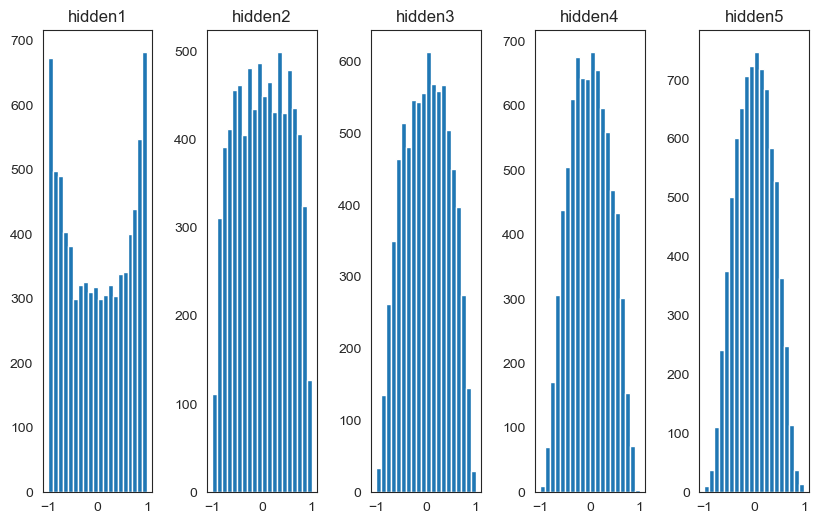

In [11]:
# sigmoid 대신 tanh를 적용
model = build_model(activations.tanh, initializers.GlorotUniform())
show_layer(model)

#### He 정규분포 초기화
* He 초기화 방법은 **표준편차가 $\sqrt{\frac{2}{n}}$를 가지도록 초기화**한다.
* 각화한 결과를 살펴보면, 활성화값 분포가 균일하게 분포되어 있다.
* 참고로 ReLU와 같은 비선형함수 일 때 더 적합하다고 알려진 초기화 방법이다.

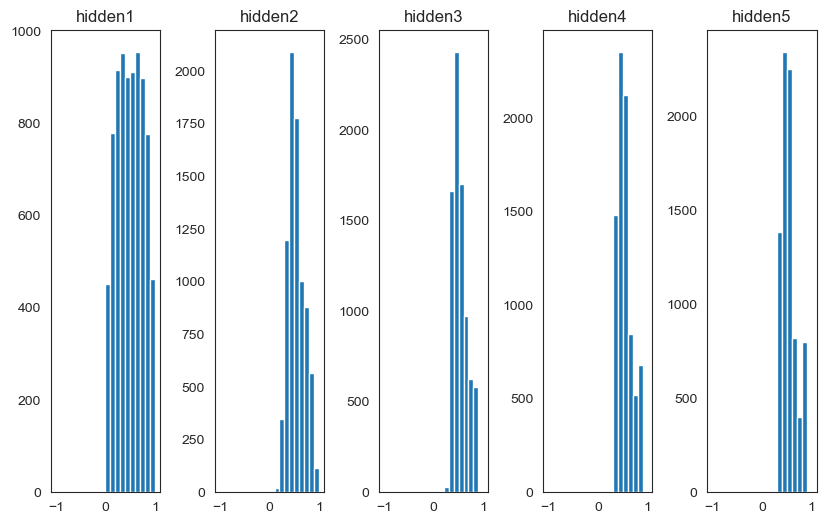

In [14]:
# HE 정규분포
model = build_model(activations.sigmoid, initializers.HeNormal())
show_layer(model)

#### He 균일분포 초기화
* He 균일분포도 정규분포와 유사하게 가중치 값들이 잘 분포되어 있음을 알 수 있다.

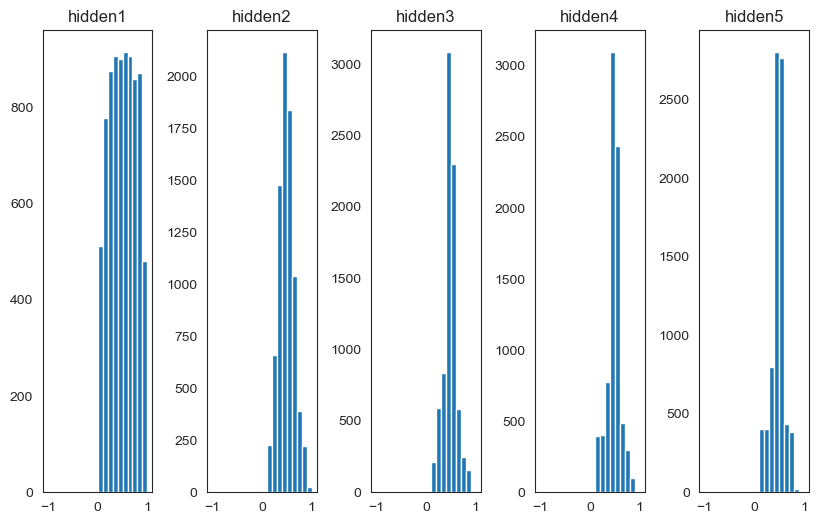

In [13]:
# HE 균일분포
model = build_model(activations.sigmoid, initializers.HeUniform())
show_layer(model)

### 비선형 한수 가중치 초기화
대표적인 비선형 활성화 함수인 activations.relu를 사용하여 초기화 방법들을 비교해보기

#### 제로 초기화
* 가중치를 제로값으로 초기화한 경우, 시각화 결과를 보면 레이어의 가중치 분포가 0에만 몰려 있는 것을 알 수 있다.
* 활성화 함수로 `relu`를 사용하였기 때문에 0인 값은 그대로 0에만 머무는 것을 알 수 있다.
> 참고: 각 레이어의 값이 0에 몰려 있는 이유는 가중치 값이 활성화 함수로 사용한 reLU 함수를 통과하였기 때문입니다. (relu(0)=0

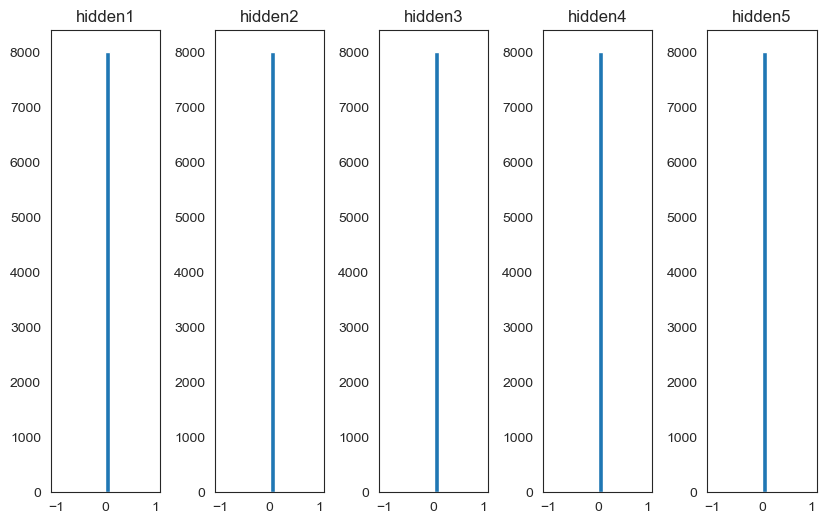

In [15]:
# 비선형 제로 초기화
model = build_model(activations.relu, initializers.Zeros())
show_layer(model)

#### 정규분포 초기화
* 제로 초기화보다는 정규분포 초기화의 경우 분포가 퍼져있는 것을 알 수 있다.
* 그러나 마찬가지로 hidden1 레이어를 제외하고는 0에 치우쳐 있는 문제가 있다.

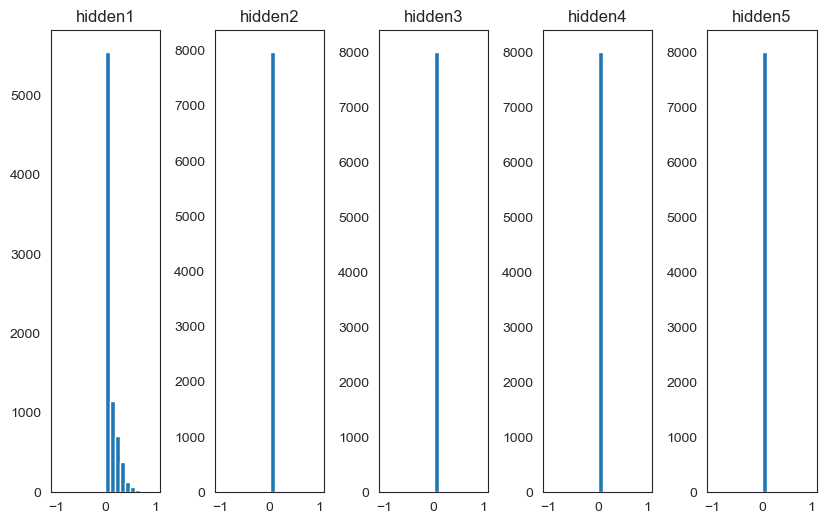

In [16]:
model = build_model(activations.relu, initializers.RandomNormal())
show_layer(model)

#### 균일분포 초기화
* 균일분포도 마찬가지로 처음 레이어를 제외하고는 가중치 값이 0에 치우쳐 있는 것을 알 수 있다.

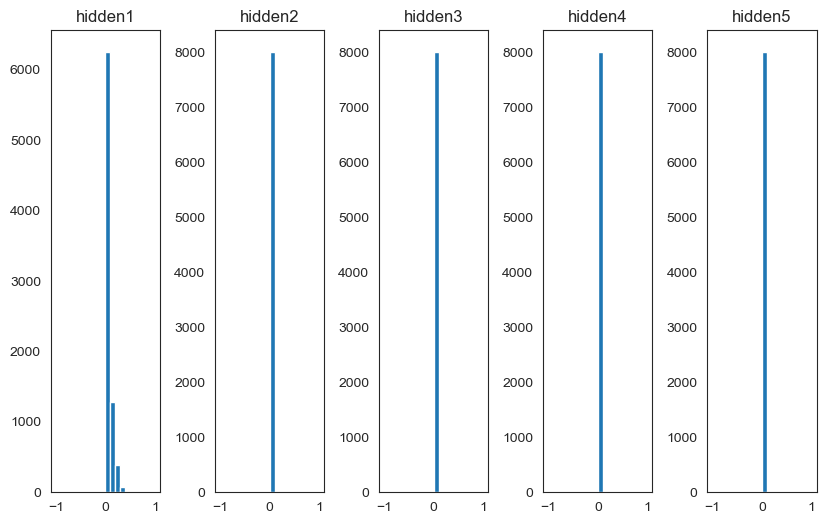

In [17]:
model = build_model(activations.relu, initializers.RandomUniform())
show_layer(model)

#### Xavier(Glorot) 정규분포 초기화
* Xavier 초기화 방법은 relu 특성상 0인 값이 많다.
* 하지만 전체 레이어를 보더라도 어느정도 분포가 퍼져있는 것을 알 수 있다.

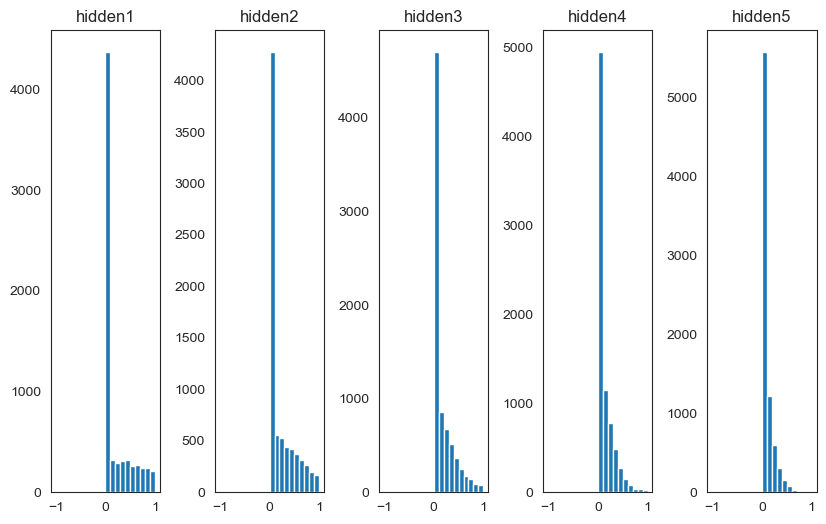

In [18]:
model = build_model(activations.relu, initializers.GlorotNormal())
show_layer(model)

#### Xavier(Glorot) 균일분포 초기화
* 균일분포도 정규분포와 유사한 형태의 분포를 보여주고 있다.

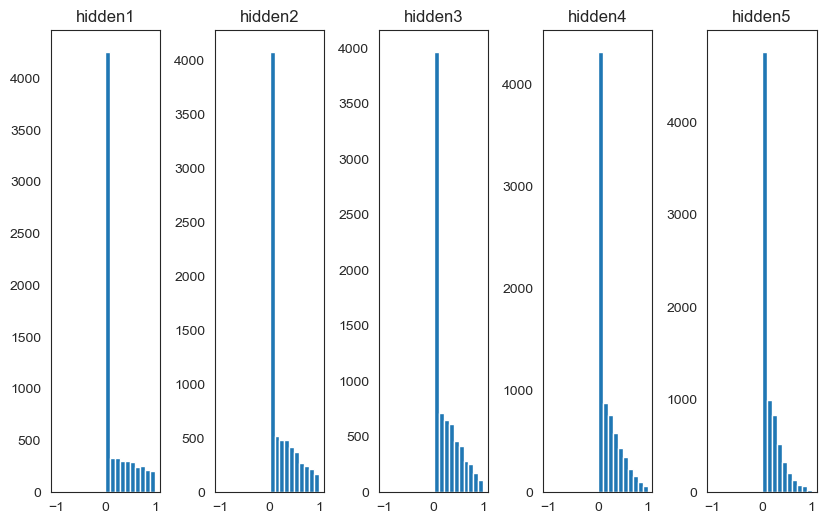

In [19]:
model = build_model(activations.relu, initializers.GlorotUniform())
show_layer(model)

#### He 정규분포 초기화
* He 초기화는 일반적으로 비선형 함수에 더 적합하다고 알려져있다.
* 시각화된 결과도 어느정도 분포가 고르게 형성되어 있음을 알 수 있다.

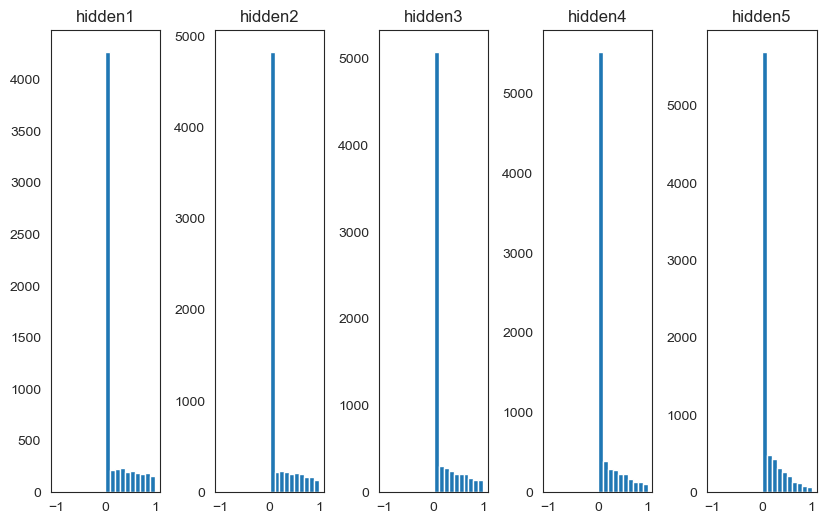

In [20]:
model = build_model(activations.relu, initializers.HeNormal())
show_layer(model)

#### He 균일분포 초기화
* 균일분포도 마찬가지로 정규분포와 유사한 모습을 보여주고 있다.

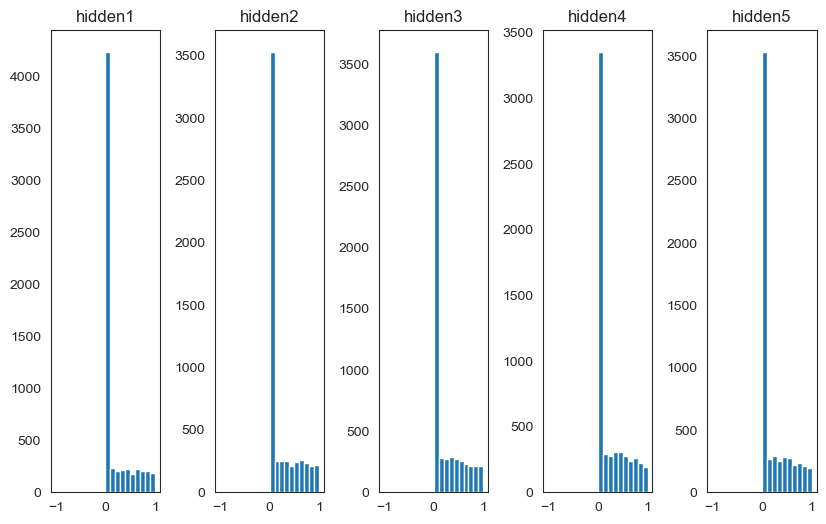

In [21]:
model = build_model(activations.relu, initializers.HeUniform())
show_layer(model)

아래 링크를 참조하여 다른 활성화 함수와 각종 초기화 방법을 적용했을 때는 어떤 결과가 나올지 아래 코드를 이용해 확인해보기
* Keras Initializers : https://keras.io/api/layers/initializers/
* Keras Activations : https://keras.io/api/layers/activations/

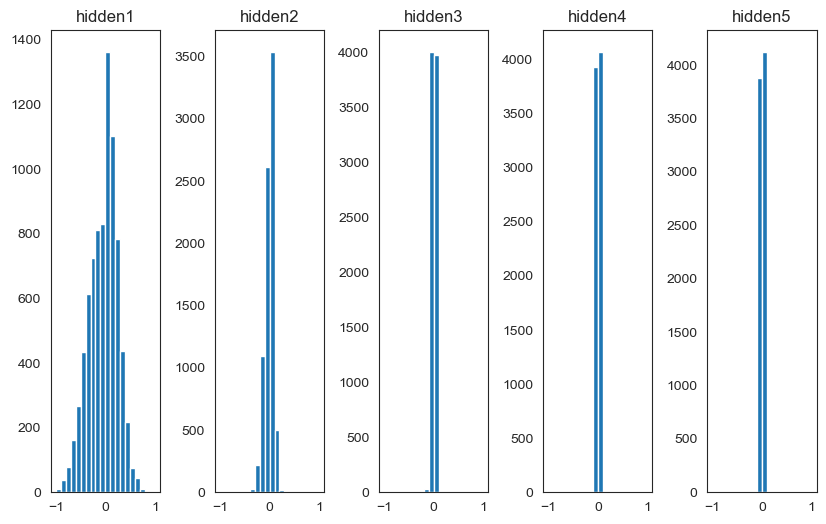

In [23]:
# [play ground]
# 사용해보고 싶은 활성화함수, 초기화 방법을 각각 activation, initializer에 입력해주세요.

from tensorflow.keras import activations, initializers

model = build_model(activations.selu, initializers.RandomNormal())
show_layer(model)

# Reuters 딥러닝 모델 예제 실습
* Reuters 데이터 셋 : https://kdd.ics.uci.edu/databases/reuters21578/reuters21578.html
* 뉴스 기사를 모아놓은 것으로 주제 분류를 위해 자주 사용하는 데이터
* 데이터셋은 뉴스 기사 텍스트와 46개의 토픽으로 구성
* Reuters 데이터셋으로 가중치 초기화 실습해보기
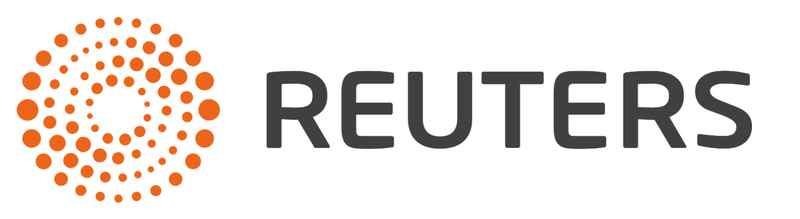

## 데이터 로드 및 전처리
* 케라스에서는 Reuters 뉴스 기사 데이터를 reuters.load_data() 함수를 통해 다운로드가 가능하다.
* 본 예제에서는 num_words를 10000개로 제한하여 데이터를 로드
* 기본적으로 8,982개의 훈련 데이터셋과 2,246개의 테스트 데이터셋으로 구분되어 있다.
* 레이블을 통해 뉴스 기사의 주제로 46개가 있는 것을 알 수 있다.

In [24]:
# 데이터 로드 및 확인
from keras.datasets import reuters
import numpy as np

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

print(len(train_data))
print(len(test_data))
print(len(set(train_labels)))

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
8982
2246
46


Reuters 데이터셋도 단어 인덱스로만 구성되어 있기 때문에 reuters.get_word_index() 함수를 통해     
얻은 단어 인덱스 딕셔너리를 이용해 인덱스를 단어들로 변환이 가능합니다.    

In [26]:
# 단어 인덱스 딕셔너리 확인하기
word_index = reuters.get_word_index()
word_index

{'mdbl': 10996,
 'fawc': 16260,
 'degussa': 12089,
 'woods': 8803,
 'hanging': 13796,
 'localized': 20672,
 'sation': 20673,
 'chanthaburi': 20675,
 'refunding': 10997,
 'hermann': 8804,
 'passsengers': 20676,
 'stipulate': 20677,
 'heublein': 8352,
 'screaming': 20713,
 'tcby': 16261,
 'four': 185,
 'grains': 1642,
 'broiler': 20680,
 'wooden': 12090,
 'wednesday': 1220,
 'highveld': 13797,
 'duffour': 7593,
 '0053': 20681,
 'elections': 3914,
 '270': 2563,
 '271': 3551,
 '272': 5113,
 '273': 3552,
 '274': 3400,
 'rudman': 7975,
 '276': 3401,
 '277': 3478,
 '278': 3632,
 '279': 4309,
 'dormancy': 9381,
 'errors': 7247,
 'deferred': 3086,
 'sptnd': 20683,
 'cooking': 8805,
 'stratabit': 20684,
 'designing': 16262,
 'metalurgicos': 20685,
 'databank': 13798,
 '300er': 20686,
 'shocks': 20687,
 'nawg': 7972,
 'tnta': 20688,
 'perforations': 20689,
 'affiliates': 2891,
 '27p': 20690,
 'ching': 16263,
 'china': 595,
 'wagyu': 16264,
 'affiliated': 3189,
 'chino': 16265,
 'chinh': 16266,
 '

In [27]:
# 인덱스 단어 딕셔너리 형태로 만들기 위해서 단어 인덱스 딕셔너리를 역으로 변환하기
index_word = dict([(value, key) for (key, value) in word_index.items()])
index_word

{10996: 'mdbl',
 16260: 'fawc',
 12089: 'degussa',
 8803: 'woods',
 13796: 'hanging',
 20672: 'localized',
 20673: 'sation',
 20675: 'chanthaburi',
 10997: 'refunding',
 8804: 'hermann',
 20676: 'passsengers',
 20677: 'stipulate',
 8352: 'heublein',
 20713: 'screaming',
 16261: 'tcby',
 185: 'four',
 1642: 'grains',
 20680: 'broiler',
 12090: 'wooden',
 1220: 'wednesday',
 13797: 'highveld',
 7593: 'duffour',
 20681: '0053',
 3914: 'elections',
 2563: '270',
 3551: '271',
 5113: '272',
 3552: '273',
 3400: '274',
 7975: 'rudman',
 3401: '276',
 3478: '277',
 3632: '278',
 4309: '279',
 9381: 'dormancy',
 7247: 'errors',
 3086: 'deferred',
 20683: 'sptnd',
 8805: 'cooking',
 20684: 'stratabit',
 16262: 'designing',
 20685: 'metalurgicos',
 13798: 'databank',
 20686: '300er',
 20687: 'shocks',
 7972: 'nawg',
 20688: 'tnta',
 20689: 'perforations',
 2891: 'affiliates',
 20690: '27p',
 16263: 'ching',
 595: 'china',
 16264: 'wagyu',
 3189: 'affiliated',
 16265: 'chino',
 16266: 'chinh',
 2

In [28]:
#train_data[0]의 각 인덱스에 매핑되는 단어들로 연결하여 하나의 리뷰를 만들어 주기
news = ' '.join([str(i) for i in train_data[0]])
news

'1 2 2 8 43 10 447 5 25 207 270 5 3095 111 16 369 186 90 67 7 89 5 19 102 6 19 124 15 90 67 84 22 482 26 7 48 4 49 8 864 39 209 154 6 151 6 83 11 15 22 155 11 15 7 48 9 4579 1005 504 6 258 6 272 11 15 22 134 44 11 15 16 8 197 1245 90 67 52 29 209 30 32 132 6 109 15 17 12'

* 단어 인덱스에서 0은 패딩을 의미하는 토큰인 `pad`
* 1은 문장의 시작을 의미하는 토큰인 `sos`
* 2는 OOV(Out Of Vocabulary)를 의미하는 토큰인 `unk` 으로 지정되어있다.
* 그러므로 i-3으로 인덱스를 맞춰주고, 해당 토큰들은 ?로 대체한다.

In [29]:
news = ' '.join([index_word.get(i-3, '?') for i in train_data[0]])
news

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

* 딥러닝 모델의 학습에 사용하기 위해서는 텍스트 데이터를 벡터로 변환해야 한다.
* 일반적으로 자주 사용되는 원-핫 인코딩(one-hot encoding)을 이용해 텍스트를 0과 1의 벡터로 변환한다.

In [30]:
# 원-핫 인코딩을 이용해 텍스트 변환하기
def one_hot_encoding(data, dim=10000):
  results = np.zeros((len(data), dim))
  for i, d in enumerate(data):
    results[i, d] = 1.
  return results

x_train = one_hot_encoding(train_data)
x_test = one_hot_encoding(test_data)

print(x_train[0])

[0. 1. 1. ... 0. 0. 0.]


In [31]:
# Reuters 데이터셋에서 레이블은 46개의 주제를 구분하기 위한 인덱스로 되어 있다.
# 몇 개의 레이블을 확인해 보기
print(train_labels[5])
print(train_labels[15])
print(train_labels[25])
print(train_labels[35])
print(train_labels[45])

4
8
1
4
20


In [32]:
# 뉴스 주제인 레이블도 원-핫 인코딩(범주형 인코딩)을 이용해 변환을 수행해 주어야한다.
# 케라스에서는 utils.to_categorical()을 이용해 쉽게 변환할 수 있다.
from tensorflow.keras import utils

y_train = utils.to_categorical(train_labels)
y_test = utils.to_categorical(test_labels)

print(train_labels[5], y_train[5])
print(train_labels[15], y_train[15])
print(train_labels[25], y_train[25])

4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
8 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## 모델 구성
* Reuters 데이터셋을 주제별로 분류하기 위한 딥러닝 모델을 정의한다.
* 순차적으로 레이어를 추가하여 단순한 모델을 생성하기 위해 Sequential() 함수를 사용
* 첫번째는 유닛수 256개, 활성화 함수는 'relu', 입력 차원은 10000, 이름은 input인 Dense 레이어를 추가
* 두번째도 마찬가지로 유닛수 256개를 가지고, relu 활성화 함수를 사용하며 이름은 hidden인 Dense 레이어를 추가
* 세번째는 뉴스 주제 갯수로 유닛수를 46개로 지정하고, 다중 분류이므로 활성화 함수는 softmax를 사용
* 이름은 output으로 지정한 Dense 레이어를 추가

In [33]:
# 딥러닝 모델 정의
import tensorflow as tf
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000, ), name='input'))
model.add(layers.Dense(128, activation='relu', name='hidden'))
model.add(layers.Dense(46, activation='softmax', name='output'))

C:\Users\nini\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 모델 컴파일 및 학습
* 정의한 모델에 사용할 옵티마이저는 rmsprop를 사용
* 손실 함수는 다중 분류이므로 categorical_crossentropy를 지정
* 지표는 accuracy를 사용하고, 모델의 구조를 summary() 함수를 통해 살펴본다.

In [35]:
# 모델 컴파일 후 summary() 확인하기
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (Dense)                        │ (None, 128)                 │       1,280,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden (Dense)                       │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 46)                  │           5,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,302,574 (4.97 MB)

 Trainable params: 1,302,574 (4.97 MB)

 Non-trainable params: 0 (0.00 B)

* 생성한 딥러닝 모델을 이용해 Reuters 데이터셋을 학습하기 위해 학습용 데이터셋으로 x_train과 y_train을 지정
* 에폭(epochs)은 40으로 지정
* 배치 사이즈는 512로 지정
* 검증을 위해서 테스트 데이터인 x_test와 y_test를 지정하여 fit() 함수를 실행

In [36]:
# 모델 학습하기
history = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_test, y_test))

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4255 - loss: 2.8771 - val_accuracy: 0.6541 - val_loss: 1.5152
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.7144 - loss: 1.2974 - val_accuracy: 0.7364 - val_loss: 1.1999
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7945 - loss: 0.9302 - val_accuracy: 0.7493 - val_loss: 1.0753
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8424 - loss: 0.7141 - val_accuracy: 0.7716 - val_loss: 1.0002
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8842 - loss: 0.5585 - val_accuracy: 0.7854 - val_loss: 0.9374
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9111 - loss: 0.4194 - val_accuracy: 0.7992 - val_loss: 0.8806
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9250 - loss: 0.3464 - val_accuracy: 0.7988 - val_loss: 0.9058
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9350 - loss: 0.2843 - val_accuracy: 0.8072 - v

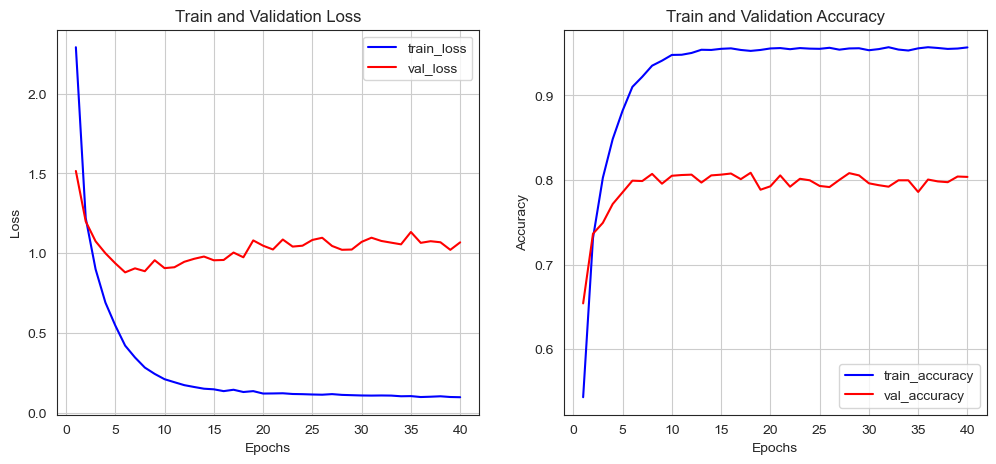

In [37]:
# 모델이 잘 학습되었는지 확인하기 위해서 loss, val_loss, accuracy, val_accuracy를 차트로 시각화

import matplotlib.pyplot as plt

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color='blue', label='train_loss')
ax1.plot(epochs, val_loss, color='red', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, color='blue', label='train_accuracy')
ax2.plot(epochs, val_accuracy, color='red', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.show()

모델의 학습 결과를 살펴보면 에폭이 진행될수록 `val_loss`는 계속 **증가**하고,     
`val_accuracy`는 조금씩 **감소**하는 것을 알 수 있습니다.     
모델은 **과대적합된 상태**인 것을 알 수 있습니다.

## 가중치 초기화
* 이제 실제 Reuters 딥러닝 모델에 가중치 초기화를 적용한 결과를 살펴보기
* 초기화 initializer에 따라 모델을 생성하는 build_model 함수를 정의
* 케라스에서는 기본적으로 레이어에 균일분포 초기화를 수행하지만, 다른 초기화 방법과 비교해보기

In [38]:
def build_model(initializer):
  model = models.Sequential()
  model.add(layers.Dense(128,
                         activation='relu', 
                         kernel_initializer=initializer,
                         input_shape=(10000, ), 
                         name='input'))
  model.add(layers.Dense(128, 
                         activation='relu', 
                         kernel_initializer=initializer,
                         name='hidden'))
  model.add(layers.Dense(46, 
                         activation='softmax', 
                         name='output'))
  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  history = model.fit(x_train, y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_test, y_test))
  return history

In [40]:
# 모델의 학습 히스토리 결과를 비교해보기 위해서 시각화하는 diff_history 함수를 정의
def diff_history(history1, history2):
  history1_dict = history1.history
  h1_loss = history1_dict['loss']
  h1_val_loss = history1_dict['val_loss']

  history2_dict = history2.history
  h2_loss = history2_dict['loss']
  h2_val_loss = history2_dict['val_loss']

  epochs = range(1, len(h1_loss) + 1)
  fig = plt.figure(figsize=(12, 5))
  plt.subplots_adjust(wspace=0.3, hspace=0.3)

  ax1 = fig.add_subplot(1, 2, 1)
  ax1.plot(epochs, h1_loss, 'b-', label='train_loss')
  ax1.plot(epochs, h1_val_loss, 'r-', label='val_loss')
  ax1.plot(epochs, h2_loss, 'b--', label='train_loss')
  ax1.plot(epochs, h2_val_loss, 'r--', label='val_loss')
  ax1.set_title('Train and Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.grid()
  ax1.legend()

  h1_accuracy = history1_dict['accuracy']
  h1_val_accuracy = history1_dict['val_accuracy']

  h2_accuracy = history2_dict['accuracy']
  h2_val_accuracy = history2_dict['val_accuracy']

  ax2 = fig.add_subplot(1, 2, 2)
  ax2.plot(epochs, h1_accuracy, 'b-', label='train_accuracy')
  ax2.plot(epochs, h1_val_accuracy, 'r-', label='val_accuracy')
  ax2.plot(epochs, h2_accuracy, 'b--', label='train_accuracy')
  ax2.plot(epochs, h2_val_accuracy, 'r--', label='val_accuracy')
  ax2.set_title('Train and Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.grid()
  ax2.legend()

  plt.show()

### 제로 초기화

In [41]:
# 가중치 값을 0으로 초기화하는 모델을 생성하여 학습
zero_history = build_model(initializers.Zeros())

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.0781 - loss: 3.8175 - val_accuracy: 0.2110 - val_loss: 3.7955
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.1452 - loss: 3.7894 - val_accuracy: 0.2110 - val_loss: 3.7726
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.2125 - loss: 3.7660 - val_accuracy: 0.2110 - val_loss: 3.7506
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.2155 - loss: 3.7449 - val_accuracy: 0.2110 - val_loss: 3.7286
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.2158 - loss: 3.7214 - val_accuracy: 0.2110 - val_loss: 3.7070
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2203 - loss: 3.7014 - val_accuracy: 0.2110 - val_loss: 3.6856
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2121 - loss: 3.6793 - val_accuracy: 0.2110 - val_loss: 3.6643
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2636 - loss: 3.6573 - val_accuracy: 0.2110 - v

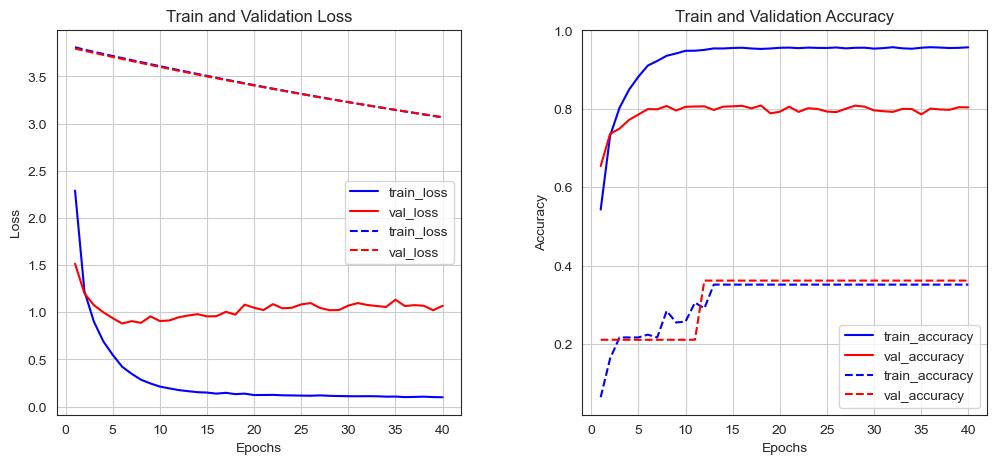

In [43]:
# 기본 모델과 제로 초기화 모델 학습 결과를 비교해보면, 제로 초기화 모델은 학습이 제대로 되고 있지 않다는 것을 알 수 있습니다.
diff_history(history, zero_history)

### 정규분포 초기화

In [44]:
# 정규분포 초기화 방법도 비교를 위해서 모델을 생성하여 학습합니다.

normal_history = build_model(initializers.RandomNormal())

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.3564 - loss: 3.0513 - val_accuracy: 0.5886 - val_loss: 1.7218
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6402 - loss: 1.5462 - val_accuracy: 0.6883 - val_loss: 1.4097
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7158 - loss: 1.2294 - val_accuracy: 0.7088 - val_loss: 1.2563
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7663 - loss: 1.0145 - val_accuracy: 0.7351 - val_loss: 1.1490
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8090 - loss: 0.8341 - val_accuracy: 0.7511 - val_loss: 1.0975
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8412 - loss: 0.6964 - val_accuracy: 0.7467 - val_loss: 1.0561
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8661 - loss: 0.5940 - val_accuracy: 0.7573 - val_loss: 1.0332
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8843 - loss: 0.5153 - val_accuracy: 0.7738 - v

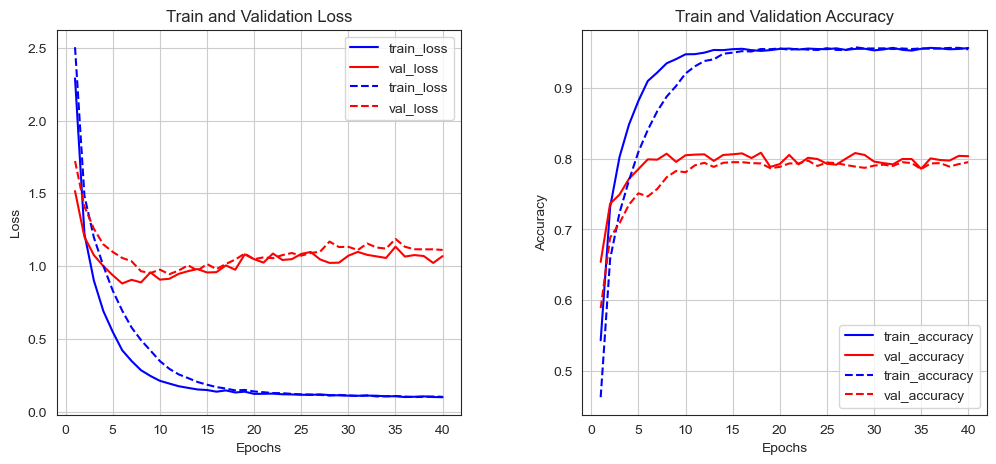

In [45]:
# 정규분포로 초기화한 결과는 기본 모델과 유사하지만 조금 더디게 학습된 것을 알 수 있습니다.
diff_history(history, normal_history)

### Xavier(Glorot) 초기화

In [47]:
# 이제 Xavier(Glorot) 초기화 방법 결과 비교를 위해서 모델을 생성하고 학습
glorot_historyㅠ = build_model(initializers.GlorotNormal())

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4285 - loss: 2.7628 - val_accuracy: 0.6839 - val_loss: 1.4619
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7226 - loss: 1.2579 - val_accuracy: 0.7386 - val_loss: 1.1823
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7980 - loss: 0.9365 - val_accuracy: 0.7600 - val_loss: 1.0571
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8432 - loss: 0.7057 - val_accuracy: 0.7787 - val_loss: 0.9630
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8801 - loss: 0.5443 - val_accuracy: 0.7796 - val_loss: 0.9610
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9066 - loss: 0.4458 - val_accuracy: 0.7845 - val_loss: 0.9224
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9230 - loss: 0.3453 - val_accuracy: 0.8019 - val_loss: 0.8688
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9421 - loss: 0.2714 - val_accuracy: 0.7876 - v

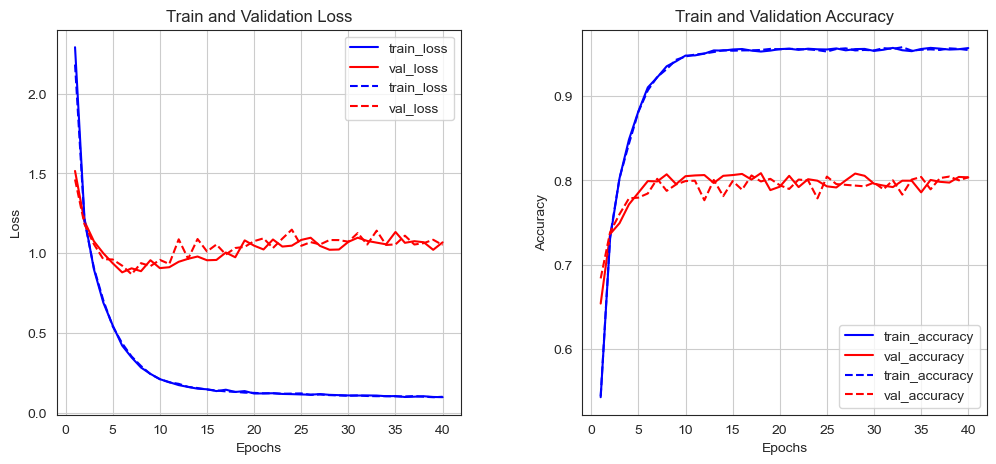

In [49]:
diff_history(history, glorot_history)

Xavier 초기화 방법은 기존 모델에서 사용하는 균일분포와 매우 유사한 형태로 학습된 것을 알 수 있습니다.

### He 초기화

In [50]:
# He 초기화 방법도 비교를 위해서 모델을 생성하고 학습합니다.
he_history = build_model(initializers.HeNormal())

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4390 - loss: 2.7304 - val_accuracy: 0.6883 - val_loss: 1.4218
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7323 - loss: 1.1862 - val_accuracy: 0.7458 - val_loss: 1.1371
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8242 - loss: 0.8122 - val_accuracy: 0.7756 - val_loss: 0.9885
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8771 - loss: 0.5750 - val_accuracy: 0.7907 - val_loss: 0.9164
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9036 - loss: 0.4578 - val_accuracy: 0.7988 - val_loss: 0.8711
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9274 - loss: 0.3374 - val_accuracy: 0.7970 - val_loss: 0.8870
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9427 - loss: 0.2640 - val_accuracy: 0.7996 - val_loss: 0.8870
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9492 - loss: 0.2144 - val_accuracy: 0.7992 - v

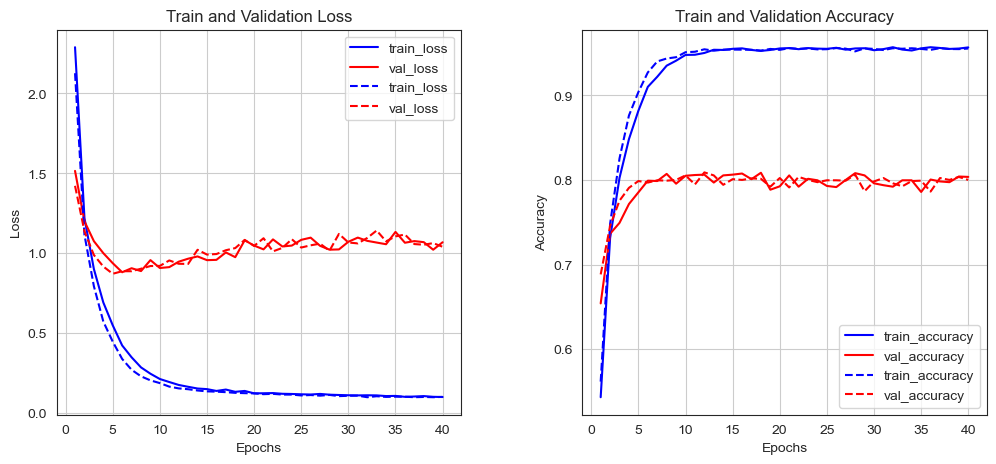

In [51]:
# 시각화
diff_history(history, he_history)

He 초기화는 기존 모델과 비교하여 작지만 좀 더 빠르게 학습된 것을 알 수 있습니다.     
현재 모델이 비선형 함수인 relu를 사용하여 He 초기화에 더 적합한 것을 알 수 있습니다.

## 실습해보기
* 위에서 시행하보지 않은 가중치 초기화 방법이 있거나 실험하고 싶은 것이 있다면 아래 코드를 이용해봅시다.

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.4437 - loss: 2.8186 - val_accuracy: 0.6830 - val_loss: 1.4461
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7472 - loss: 1.1910 - val_accuracy: 0.7516 - val_loss: 1.1313
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8258 - loss: 0.8142 - val_accuracy: 0.7801 - val_loss: 1.0154
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8720 - loss: 0.6057 - val_accuracy: 0.7676 - val_loss: 0.9694
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9039 - loss: 0.4648 - val_accuracy: 0.7600 - val_loss: 1.0006
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9282 - loss: 0.3617 - val_accuracy: 0.8001 - val_loss: 0.8852
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9409 - loss: 0.2756 - val_accuracy: 0.7965 - val_loss: 0.8868
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9477 - loss: 0.2268 - val_accuracy: 0.7930 - v

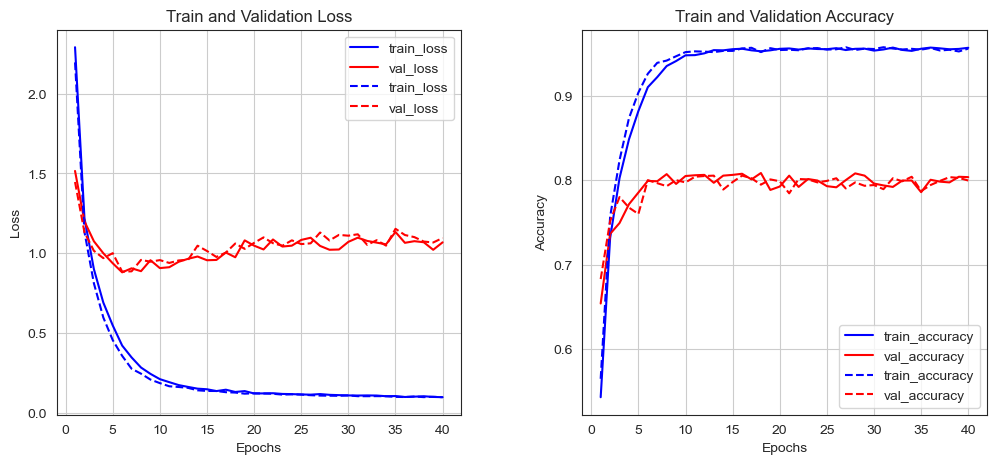

In [56]:
# [play ground]
# 이번 build_model() 함수의 인자는 각각 가중치 초기화 방법 하나입니다.

your_history = build_model(initializers.HeUniform())
diff_history(history, your_history)

# 배치 정규화(Batch Normalization)
* 배치 정규화는 모델에 입력되는 샘플들을 균일하게 만드는 방법 > 정규화 시키는 것
* 가중치의 활성화값이 적당히 퍼지게끔 '강제'로 적용시키는 것을 의미
* 보통 미니배치 단위로 데이터의 평균이 0, 표준편차는 1로 정규화를 수행
* 학습 자체가 빨리 진행될 수 있도록 만들어주고, 학습 후에도 새로운 데이터에 일반화가 잘 될 수 있도록 도와줌
* 초기값에 크게 의존하지 않아도 되고 (그때 그때 정규화 과정을 거치지 않기 때문), 과대적합을 방지하는 역할을 수행
* 배치 정규화는 데이터 전처리 단계에서 진행해도 되지만 정규화가 되어서 레이어에 들어갔다는 보장이 없으므로 주로 Dense 레이어 이후 활성화 함수 이전에 활용
* 핵심 : 들어온 데이터를 배치 단위로 평균이 0, 표준편차가 1인 데이터로 조정해주는 일이며 학습 속도 증가와 과대적합을 방지할 수 있습니다.
  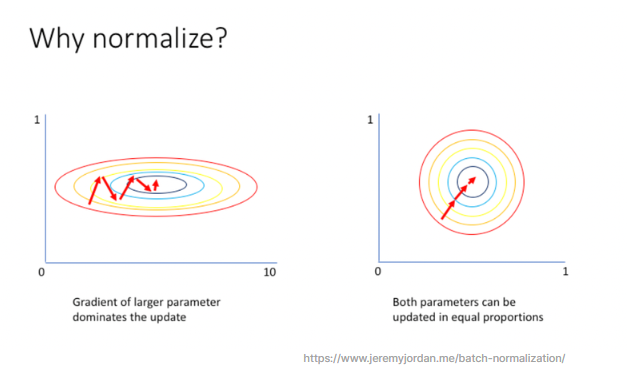

## 모델 구성 및 컴파일 (실습)
Reuters 데이터셋에 대해 뉴스 주제를 분류하는 딥러닝 모델에서 기존에 정의했던     
3개의 Dense 레이어 사이에 배치 정규화를 위해 BatchNormalization() 레이어를 추가합니다.    
일반적으로 Dense 레이어와 Activation 활성함수 레이어 사이에 추가해야 합니다.

In [57]:
import tensorflow as tf
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Dense(128, input_shape=(10000, ), name='input'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu')) 
model.add(layers.Dense(128, name='hidden'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu')) 
model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (Dense)                        │ (None, 128)                 │       1,280,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden (Dense)                       │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 46)                  │           5,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,303,598 (4.97 MB)

 Trainable params: 1,303,086 (4.97 MB)

 Non-trainable params: 512 (2.00 KB)

In [58]:
batch_norm_history = model.fit(x_train, y_train,
                               epochs=40,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.5012 - loss: 2.3940 - val_accuracy: 0.7467 - val_loss: 3.3408
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8728 - loss: 0.6870 - val_accuracy: 0.7520 - val_loss: 3.1090
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9375 - loss: 0.3606 - val_accuracy: 0.7137 - val_loss: 2.8096
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9541 - loss: 0.2197 - val_accuracy: 0.6995 - val_loss: 2.4287
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9543 - loss: 0.1710 - val_accuracy: 0.6937 - val_loss: 2.0887
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9556 - loss: 0.1427 - val_accuracy: 0.7159 - val_loss: 1.7947
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9582 - loss: 0.1205 - val_accuracy: 0.7280 - val_loss: 1.6146
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9562 - loss: 0.1157 - val_accuracy: 0.7467 - v

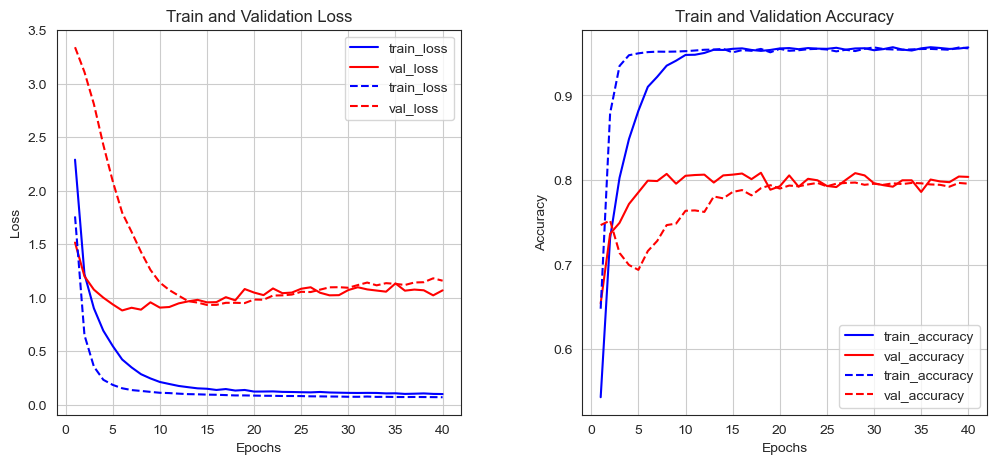

In [59]:
diff_history(history, batch_norm_history)

기본 모델과 배치 정규화를 적용한 모델을 비교해보면, 배치 정규화를 적용한 모델이 좀 더 빠르고 안정되게 학습이 되는 것을 알 수 있습니다.

## 실습해보기
* 배치 정규화에 대해선 아직도 밝혀지지 않은 부분이 많아 꾸준히 연구가 진행되고 있습니다.
* 배치 정규화의 위치 역시 연구중인 분야로 활성화 함수 다음에 적용해야한다는 주장도 있습니다.
* 아래에서는 활성화 함수 다음에 BatchNormalization() 레이어를 추가하고 성능을 비교해보기

In [60]:
# [play ground]

model = models.Sequential()
model.add(layers.Dense(128, input_shape=(10000, ), name='input'))

# 활성화 함수를 Dense 레이어와 같이 선언할 수도 있지만 단순히 위 코드에서 순서를 바꾸어도 동일하게 동작합니다.
model.add(layers.Activation('relu')) 
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, name='hidden'))
model.add(layers.Activation('relu')) 
model.add(layers.BatchNormalization())
model.add(layers.Dense(46, activation='softmax', name='output'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (Dense)                        │ (None, 128)                 │       1,280,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden (Dense)                       │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 46)                  │           5,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,303,598 (4.97 MB)

 Trainable params: 1,303,086 (4.97 MB)

 Non-trainable params: 512 (2.00 KB)

In [61]:
orderd_bn_history = model.fit(x_train, y_train,
                               epochs=40,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.5312 - loss: 2.3115 - val_accuracy: 0.7373 - val_loss: 3.3893
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9116 - loss: 0.5128 - val_accuracy: 0.7422 - val_loss: 3.1881
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9483 - loss: 0.2852 - val_accuracy: 0.7271 - val_loss: 2.9464
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9555 - loss: 0.2012 - val_accuracy: 0.7520 - val_loss: 2.7136
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9560 - loss: 0.1632 - val_accuracy: 0.7516 - val_loss: 2.4348
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9555 - loss: 0.1539 - val_accuracy: 0.7600 - val_loss: 2.1943
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9592 - loss: 0.1289 - val_accuracy: 0.7596 - val_loss: 1.9501
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9547 - loss: 0.1217 - val_accuracy: 0.7551 - v

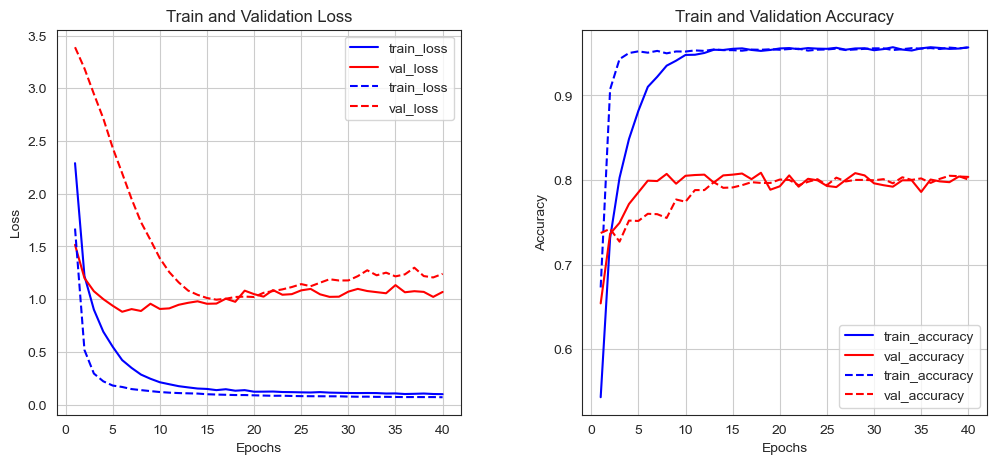

In [62]:
diff_history(history, orderd_bn_history)

# 최종 학습 정리
모델에 필요한 가중치 초기화와 배치 정규화에 대해 학습했다.    
    
가중치 초기화는 신경망 성능에 큰 영향을 주는 요소로 적절한 가중치 값이 주어지지 않을 경우     
가중치 중 확성화 되는 부분이 매우 적거나 편향될 수 있기 때문에 모델의 활성화 값이 골고루 분포 되도록 사용한다.    
가중치 초기화는 크게 활성화 함수와 비선형 함수로 나누어서 볼 수 있으며 여러개의 초기화 모델에 대해 학습을 했다.    
    
배치 정규화는 모델에 입력되는 샘플을 균일하게 만드는 정규화 작업으로     
가중치의 활성값이 퍼지게끔 '강제'로 적용시키는것을 의미한다.    
Dense 레이어 이후 활성화 함수 이전에 활용되며 들어온 데이터를 배치 단위로     
평균이 0, 표준편차가 1인 데이터로 조정해주는 일이며 학습 속도 증가와 과대적합을 방지할 수 있다.    